# Project: Machine Learning Capstone - Predict Movie Revenue (Baseline)

This project works with the datasets from the Kaggle competition at https://www.kaggle.com/c/tmdb-box-office-prediction/data to create a model for predicting worldwide box office revenue for movies.

There are 3000 movies in the sample data set being used for training and testing. The model created from this will then be used on a separate dataset to score the accuracy of predictions. The sample set contains 23 columns, of which 7 columns each contain JSON array data of objects. These objects, along with other fields, will require pre-processing into individual table columns for use in modeling. The fields the will be focuse on are:

* **belongs_to_collection**: Indicates whether this movie is part of a series, and if so which series. Will be one-hot encoded as col_0 for none or col_X where X is the associated collection.
* **budget**: Budget for film as an integer. Some entries have a budget of 0. It will be interesting to try the model both with and without this column as a consideration.
* **genres**: Indicates the genres to which the film belongs. Will be one-hot encoded as gen_X where X is the associated genre.
* **homepage**: Lists the URL for the homepage of the movie, if any. Will be encoded to 0 or 1 to indicate only whether the movie had a homepage.
* **original_language**: Gives the ISO language value for the film. Will be one-hot encoded to lan_ISO where ISO is the ISO language value.
* **popularity**: Long number value rating the film's popularity. This would not be a known value for future film productions, so it will be interesting to try modeling both with and without this value considered.
* **production_companies**: Indicates production companies involved in the movie. Will be one-hot encoded as pcom_X where X is the id of the production company.
* **production_countries**: Indicates countries where the movie was filmed or produced. Will be one-hot encoded as pcou_ISO where ISO is the ISO_3166_1 country value.
* **release_date**: The release date for the film in mm/dd/yyyy format. Will be encoded to r_year and r_week columns, where r_week is the number of the week in the year in which the file was relesed (0-51)
* **runtime**: Integer value for the runtime of the film in minutes.
* **spoken_languages**: Indicates the languages spoken in the movie. Will be one-hot encoded to spo_ISO where ISO is the ISO_639-1 language value.
* **Keywords**: Indicates the keyword values associated with the movie. Keyword objects have the format {'id': int, 'name': ''}, so these will be encoded to key_X where X is the keyword id.
* **cast**: Indicates cast members associated with the movie. Will be one-hot encoded to cast_X where X is the id of the cast member.
* **crew**: Indicates crew members associated with the movie. Will be one-hot encoded to crew_X where X is the id of the crew member.
* **revenue**: Integer value for the worldwide revenue of the movie.

In [69]:
# Import libraries necessary for this project
import sys
sys.path.insert(0, 'utilities')

import numpy as np
import pandas as pd
import json
import ast
from sklearn.model_selection import ShuffleSplit
from fix_missing_data import fixTrainRevenueAndBudget
from fix_missing_data import fixTrainRuntime
from fix_missing_data import fixLowDollars


# Import supplementary visualizations code visuals.py
#import visuals as vs

# Pretty display for notebooks
%matplotlib inline


# Load the movies dataset
train = pd.read_csv('data/train.csv')

# Drop useless columns
train = train.drop(['imdb_id', 'belongs_to_collection', 'genres', 'homepage', 'original_language', \
                    'production_companies', 'poster_path', 'original_title', 'overview', 'poster_path',\
                    'production_countries', 'release_date', 'spoken_languages', 'status', 'tagline',\
                    'title', 'Keywords', 'cast', 'crew'], axis = 1)

# Fill missing revenue and budget numbers
train = fixTrainRevenueAndBudget(train)

# Fill missing runtime numbers
train = fixTrainRuntime(train)

# Fill dollar amounts represent in millions
train = fixLowDollars(train)



#print(train.head(3))

# Success
print("Movies dataset has {} data points with {} variables each.".format(*train.shape))
print("Dataframe fields {}".format(list))
#print("Column names {}".format(list(data)))


Movies dataset has 3000 data points with 5 variables each.
Dataframe fields <class 'list'>


In [70]:
# Explore some basic statistics regarding revenue
train_revenue = train['revenue']
minimum_rev = np.amin(train_revenue)
maximum_rev = np.amax(train_revenue)
mean_rev = np.mean(train_revenue)
median_rev = np.median(train_revenue)
std_rev = np.std(train_revenue)

print("Stats for dataset:\n")
print("Minimum revenue: ${}".format(minimum_rev))
print("Maximum revenue: ${}".format(maximum_rev))
print("Mean revenue: ${}".format(mean_rev))
print("Median revenue: ${}".format(median_rev))
print("Standard deviation of revenue: ${}".format(std_rev))

Stats for dataset:

Minimum revenue: $1
Maximum revenue: $1519557910
Mean revenue: $66724027.116333336
Median revenue: $16928630.0
Standard deviation of revenue: $137476234.10861793


In [71]:
# Do final quality inspection and cleanup on the data
print("Checking that data has been reformatted")
label_arr = ['id', 'budget', 'popularity', 'runtime', 'revenue']
count = 0
for label in label_arr:
    try:
        print("Found {}: {}".format(label, train_features.loc(0, label)))
        count = count + 1
    except:
        count = count
if count == 0:
    print("All original fields have been properly transformed and disposed")
else:
    print("All original fields have not been properly dealt with. See above.")
        
print ("Checking for bad value types")
count = 0
columns = list(train_features.columns.values)
for x in columns:
    val = train_features.loc[0, x]
    
    if isinstance(val, str) or isinstance(val, list) or isinstance(val, dict) or isinstance(val, tuple):
        print("Maybe bad column {} : {}".format(x, val))
        count = count + 1
        train = train_features.drop(x, axis = 1)
    else:
        train.loc[train_features[x].isnull(), x] = 0

    
print("There are {} columns with suspect values".format(count))


Checking that data has been reformatted
All original fields have been properly transformed and disposed
Checking for bad value types
There are 0 columns with suspect values


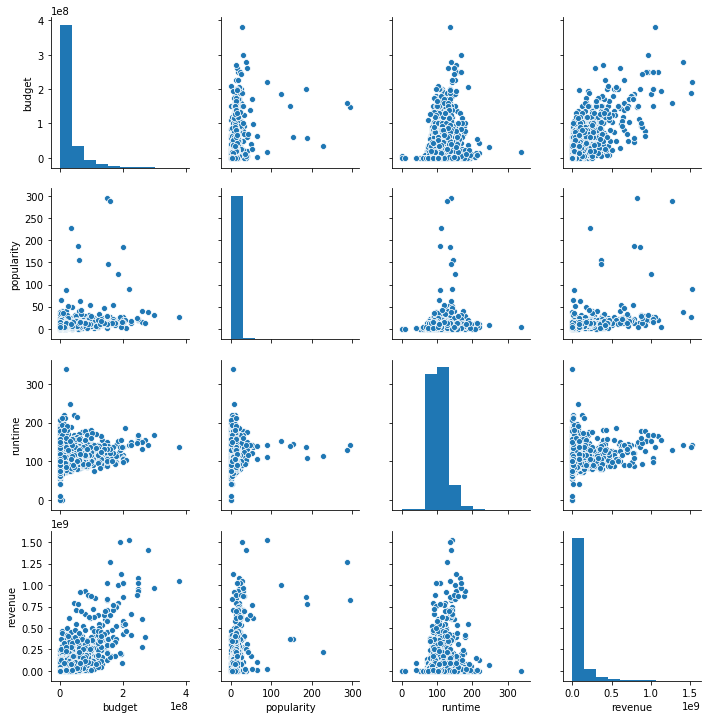

In [72]:
# Do a visualization for correlations between our already numeric values
import seaborn as sns

fields = ['budget', 'popularity', 'runtime', 'revenue']
sns.pairplot(train[fields].dropna())

In [73]:
train_revenue = train['revenue']
train_features = train.drop('revenue', axis = 1)

# Shuffle and split the training set data to prepare for training
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_features, train_revenue, test_size=.2, random_state=42)
print("Training and testing split successful")


print("train_revenue: {}".format(train_revenue.shape))
print("train_features: {}".format(train_features.shape))

Training and testing split successful
train_revenue: (3000,)
train_features: (3000, 4)


ShuffleSplit sets: ShuffleSplit(3000, n_iter=10, test_size=0.2, random_state=0)
Visualize training set sizes: [   1  301  600  900 1200 1500 1800 2099 2399]
Evaluating depth 1
Results for depth 1: [-0.46658877  0.29033064  0.32928962  0.31362965  0.3097127   0.30456712
  0.29369417  0.29350156  0.29387471]
Evaluating depth 3
Results for depth 3: [-0.46658877  0.40599347  0.44424523  0.443969    0.47514743  0.46844504
  0.47536382  0.48952878  0.51308301]
Evaluating depth 4
Results for depth 4: [-0.46658877  0.39048986  0.39165054  0.40229519  0.4326231   0.4644142
  0.42116959  0.46239884  0.51675242]
Evaluating depth 5
Results for depth 5: [-0.46658877  0.34465764  0.38595621  0.36149204  0.38738471  0.45203533
  0.36904919  0.40992297  0.48502444]
Evaluating depth 6
Results for depth 6: [-0.46658877  0.3414003   0.33803002  0.30086231  0.34808745  0.37648301
  0.31477324  0.3527188   0.43186229]
Evaluating depth 10
Results for depth 10: [-0.46658877  0.23921834  0.20057233  0.2365772

/home/doug/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


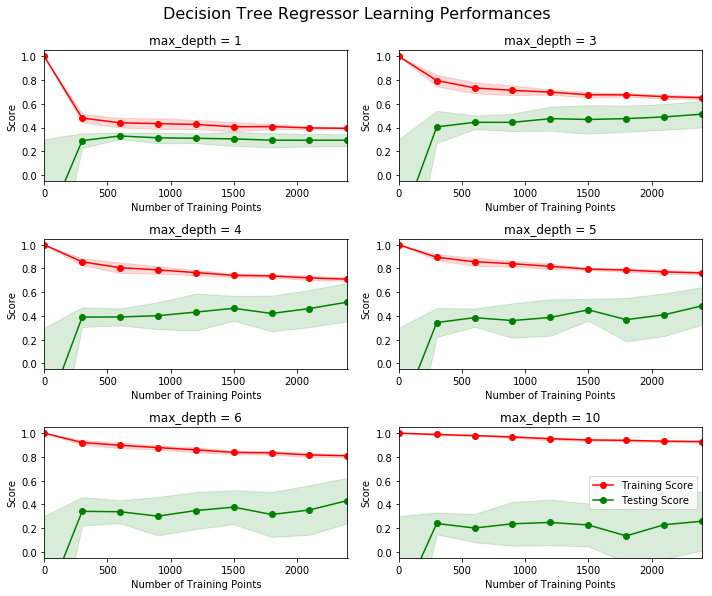

In [75]:
import plots

plots.VisualizeModelLearning(train_features, train_revenue)
    

In [76]:
# Define root mean squared function
def rmsle(y_true, y_predict):
    sum = 0.0
    for x in range(len(y_predict)):
        if y_predict[x] < 0 or y_true.iloc[x] < 0:
            continue
        p = np.log(y_predict[x] + 1)
        r = np.log(y_true.iloc[x] + 1)
        sum = sum + (p - r) ** 2
    return (sum / len(y_predict)) ** 0.5

In [77]:
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

def fit_model(X,y):
    # Create cross-validation sets
    cv_sets = ShuffleSplit(n_splits = 10, test_size = .2, train_size = None, random_state = None)
    # Decision tree regressor
    regressor = LinearRegression()
    # Dictionary for max_depth with a range of 1 to 10
    params = {'fit_intercept':[True, False],'normalize': [True,False]}
    # Use rmsle as the scoring function
    scoring_func = make_scorer(rmsle, greater_is_better=False)
    
    # Create grid search
    grid = GridSearchCV(estimator = regressor, param_grid = params, scoring = scoring_func, cv = cv_sets)
    
    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)
    
    # Return the optimal model after fitting the data
    return grid.best_estimator_


In [78]:
reg = fit_model(X_train, y_train)

# Check max_depth
print("model is {}".format(reg))

model is LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)


In [81]:
# Make predictions using the model and compare them to the real outcomes
predicted = reg.predict(X_test)
for x in range(20):
    print("Predicted: {}        Real: {}".format(int(predicted[x]), y_test.iloc[x]))

Predicted: -4542810        Real: 9247881
Predicted: -7607952        Real: 7
Predicted: -6995671        Real: 33700
Predicted: 256490185        Real: 10017322
Predicted: -9617168        Real: 8910819
Predicted: 121635576        Real: 141069860
Predicted: 39880270        Real: 68572378
Predicted: 30439592        Real: 25000000
Predicted: 47378727        Real: 40485039
Predicted: 59132797        Real: 67192859
Predicted: 33863960        Real: 53191886
Predicted: -10740069        Real: 11000000
Predicted: 15065678        Real: 55240
Predicted: 1348272        Real: 2500000
Predicted: 75151834        Real: 7563728
Predicted: 63484707        Real: 16863583
Predicted: 19059018        Real: 123820
Predicted: 55988641        Real: 174999005
Predicted: 315863570        Real: 186053725
Predicted: 48764498        Real: 87000000


In [82]:
# Get the score for predicted vs actual
score = rmsle(y_test, predicted)

print("Final model score: {}".format(score))

Final model score: 1.6401099366269307
